In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/My Drive/Brain Tumor/Brain_Tumor.zip"

Archive:  /content/gdrive/My Drive/Brain Tumor/Brain_Tumor.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1004).

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [5]:
# getting the count of number of images in each class: 0-Brain Tumor  1-healthy
ROOT_DIR="/content/Brain Tumor Data Set/Brain Tumor Data Set"
number_of_images={}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

In [6]:
number_of_images.items()

dict_items([('Brain Tumor', 2513), ('Healthy', 2087)])

# The data will be splitted as:
* 70% for training data
* 15% for Validation
* 15% for testing

In [7]:
# Function to create training, validation and test set.
def dataFolder(path,split):
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+path+"/"+dir)

      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                  size=(math.floor(split*number_of_images[dir]-5)),
                                  replace=False):
       O=os.path.join(ROOT_DIR,dir,img)
       D=os.path.join("./"+path,dir)
       shutil.copy(O,D)
       os.remove(O)
  else:
    print(f"{path} already exists")

In [8]:
dataFolder("train",0.7)

In [9]:
dataFolder("val",0.15)

In [10]:
dataFolder("test",0.15)

In [11]:
# getting the count of number of images in each class: 0-Brain Tumor  1-healthy
ROOT_DIR="/content/Brain Tumor Data Set/Brain Tumor Data Set"
number_of_images={}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))
number_of_images.items()

dict_items([('Brain Tumor', 17), ('Healthy', 16)])

# Building the Model

In [12]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [13]:
# CNN Model
model=Sequential()

model.add(Conv2D(filters=16 , kernel_size=(3,3) , activation="relu" , input_shape=(224,224,3) ))

model.add(Conv2D(filters=36 , kernel_size=(3,3) , activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64 , kernel_size=(3,3) , activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128 , kernel_size=(3,3) , activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64 , activation="relu"))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1 , activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [14]:
model.compile(optimizer="Adam" , loss=keras.losses.binary_crossentropy , metrics=["accuracy"])

# Preparing the data using Data Generator

In [15]:
def preprocessingImages1(path):
  '''
  Input : Path
  Output: Pre-Processed images
  '''

  image_data= ImageDataGenerator(zoom_range=0.2 , shear_range=0.2 , rescale=1/225 , horizontal_flip=True )
  image= image_data.flow_from_directory(directory=path , target_size=(224,224) , batch_size=32 , class_mode='binary')

  return image

In [16]:
path="/content/train"
train_data=preprocessingImages1(path)

Found 3209 images belonging to 2 classes.


In [17]:
def preprocessingImages2(path):
  '''
  Input : Path
  Output: Pre-Processed images
  '''

  image_data= ImageDataGenerator(rescale=1/225 )
  image= image_data.flow_from_directory(directory=path , target_size=(224,224) , batch_size=32 , class_mode='binary')

  return image

In [18]:
path="/content/test"
test_data=preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [19]:
path="/content/val"
val_data=preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [20]:
# Early Stopping and Model Check Point
from keras.callbacks import ModelCheckpoint,EarlyStopping

# Early Stopping
es=EarlyStopping(monitor="val_accuracy" , min_delta=0.01 , patience=6 , verbose=1 , mode='auto')

# Model Check Point
mc=ModelCheckpoint(monitor="val_accuracy" , filepath="./bestmodel.h5", verbose=1 , save_best_only=True , mode='auto')

cd=[es,mc]

# Model Training

In [21]:
hs = model.fit_generator (generator= train_data ,
                          steps_per_epoch= 8 ,
                          epochs= 30 ,
                          verbose= 1 ,
                          validation_data= val_data ,
                          validation_steps= 16 ,
                          callbacks= cd )

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.5430
Epoch 1: val_accuracy improved from -inf to 0.52930, saving model to ./bestmodel.h5
8/8 [==============================] - 22s 1s/step - loss: 0.8448 - accuracy: 0.5430 - val_loss: 0.6850 - val_accuracy: 0.5293
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.5938
Epoch 2: val_accuracy improved from 0.52930 to 0.64453, saving model to ./bestmodel.h5
8/8 [==============================] - 7s 873ms/step - loss: 0.6723 - accuracy: 0.5938 - val_loss: 0.6276 - val_accuracy: 0.6445
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.6094
Epoch 3: val_accuracy improved from 0.64453 to 0.68750, saving model to ./bestmodel.h5
8/8 [==============================] - 8s 1s/step - loss: 0.6455 - accuracy: 0.6094 - val_loss: 0.6161 - val_accuracy: 0.6875
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.6516 - accuracy:

In [22]:
# Model Graphcal Interpretation
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

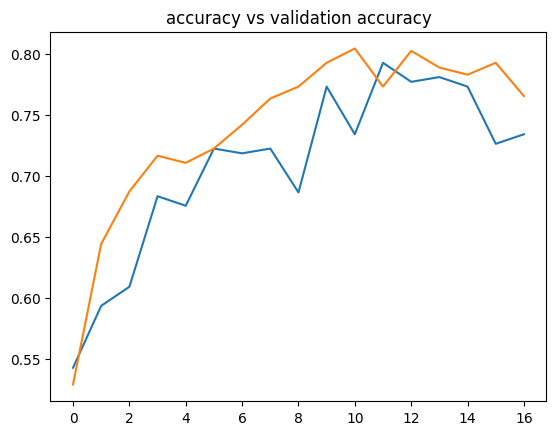

In [23]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])

plt.title('accuracy vs validation accuracy')
plt.show()

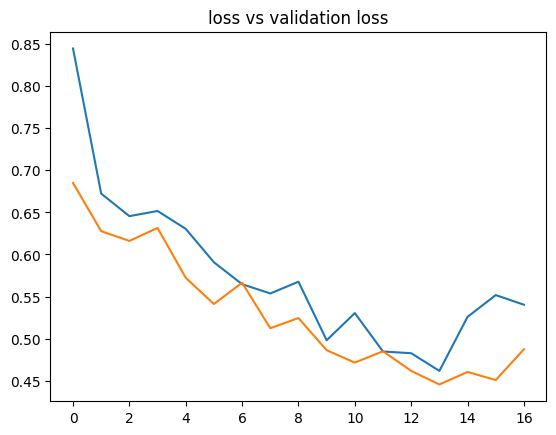

In [24]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])

plt.title('loss vs validation loss')
plt.show()

In [38]:
# Model Accuracy
from keras.models import load_model
model = load_model("/content/bestmodel.h5")

# Model Accuracy

In [39]:
acc = model.evaluate_generator(test_data)[1]
print(f"The accuracy of the Model is {acc}")

The accuracy of the Model is 0.7923416495323181


In [41]:
from tensorflow.keras.utils import load_img,img_to_array

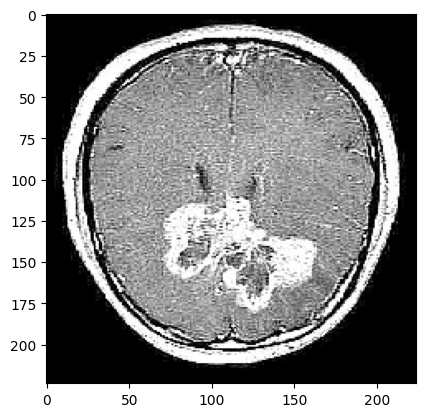

1/1 [==============================] - 0s 65ms/step
0.22640218
MRI is having a Tumor


In [60]:
path="/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1338).jpg"
img = load_img(path , target_size=(224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape
input_arr = np.expand_dims(input_arr , axis=0)
pred = model.predict(input_arr)[0][0]

print(pred)

if pred<0.5:
  print("MRI is having a Tumor")
else:
  print("MRI is not having a Tumor")